#**Bagging and Random Forest Classifier on MNIST**

In [2]:
#@title Import Basic Libraries

import numpy as np
import pandas as pd
from pprint import pprint
import os
import io
import warnings

#to amke this notebook's output stable across runs
np.random.seed(42)

#sklearn datasets
from sklearn.datasets import fetch_california_housing
from keras.datasets import mnist

#sklearn metrics for classification
from sklearn.metrics import log_loss
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve

#sklearn metrics for regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score


#sklearn for model_selection
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.model_selection import validation_curve


#sklearn pre-processing
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder

#sklearn pipeline
from sklearn.pipeline import make_pipeline, Pipeline

#sklearn compose module
from sklearn.compose import ColumnTransformer

#sklearn impute module
from sklearn.impute import SimpleImputer

#sklearn dummy
# from sklearn.dummy import DummyClassifier

#sklearn linear model
# from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression

#sklearn tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

from sklearn import tree
from sklearn.tree import export_text

#scipy
from scipy.stats import loguniform

#To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

# #global settings
# mpl.rc('axes',labelsize=14)
# mpl.rc('xtick',labelsize=12)
# mpl.rc('ytick',labelsize=12)
# mpl.rc('figure',figsize=(8,6))


##Loading MNISt dataset

In [ ]:
#Load Dataset
(X_train, y_train),(X_test, y_test)=mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
#Flatten each input image into a vector of length 784
X_train=X_train.reshape(X_train.shape[0],28*28)
X_test=X_test.reshape(X_test.shape[0],28*28)

#Normalizing
X_train=X_train/255
X_test=X_test/255


In [ ]:
print('Shape of training data after flatterning', X_train.shape)
print('Shape of testing data after flattening', X_test.shape)

Shape of training data after flatterning (60000, 784)
Shape of testing data after flattening (10000, 784)


We use `ShuffleSplit` cross validation with 10 splits and 20% data set aside for model evaluation as a test data

In [ ]:
cv=ShuffleSplit(n_splits=10,test_size=0.2,random_state=42)

We define two functions:
1. `train_classifiers` contains a common code for training classifiers for MNIST multiclass classification problem
  - It takes `estimator`, feature matrix, labels, cross validation strategy and name of the classifier as input.
  - It first fits the estimator with feature matrix and labels
  - IT obtains cross validated `f1_macro` score for training set with 10-fold `ShuffleSplit` cross validation and prints it

In [ ]:
def train_classifiers(estimator, X_train,y_train,cv,name):
  estimator.fit(X_train, y_train)
  cv_train_score=cross_val_score(estimator,X_train, y_train,
                                 cv=cv, scoring='f1_macro')
  print(f"On an average, {name} model has f1 score of "
        f"{cv_train_score.mean():.3f} +/- {cv_train_score.std():.3f} on the training side.")

2. The `eval` function takes estimator, test feature matrix and lavels as input and produce classification report and confusion matrix
  - It first predicts labels for the test set
  - The it uses these predicted reports for calculating varopus eva;uation metrics like precision, recall, f1 score and accuracy for each of the 10 classes
  - IT alos obtains a confusion matrix by comparing these predictions with the actual labels and displays it with

In [ ]:
def eval(estimator, X_test,y_test):
  y_pred=estimator.predict(X_test)
  print('# Classification report')
  print(classification_report(y_test, y_pred))

  print('#Confusion Matrix')
  disp=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred))
  disp.plot()
  plt.title('Confusion matrix')
  plt.show()

Let's train 3 classifiers with default parameters.
- **Decision tree**
- **Bagging classifier** which uses decision tree as a default classifier and trains multiple decision tree classifiers on different bags obtained through bootstrap sampling of training set.
- **Random forest classifier** which is also a bagging technique which trains different decision tree classifiers by randomly selecting attributes for splitting on bags of bootstrap sample of training set

##**Decision tree for MNIST multiclass classification**

In [ ]:
decision_tree_pipeline=Pipeline([('classifier',DecisionTreeClassifier())])
train_classifiers(decision_tree_pipeline,X_train,y_train.ravel(),cv,"decision_tree")

On an average, decision_tree model has f1 score of 0.867 +/- 0.003 on the training side.


# Classification report
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       980
           1       0.95      0.96      0.95      1135
           2       0.86      0.86      0.86      1032
           3       0.83      0.85      0.84      1010
           4       0.86      0.87      0.87       982
           5       0.85      0.83      0.84       892
           6       0.90      0.88      0.89       958
           7       0.91      0.90      0.91      1028
           8       0.82      0.81      0.81       974
           9       0.85      0.85      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.88      0.88      0.88     10000

#Confusion Matrix


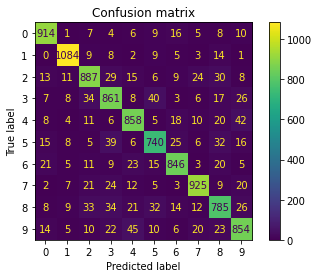

In [ ]:
eval(decision_tree_pipeline,X_test,y_test)

##**MNIST classification with Bagging**

On an average, bagging model has f1 score of 0.936 +/- 0.005 on the training side.
# Classification report
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.94      0.94      1032
           3       0.92      0.93      0.92      1010
           4       0.95      0.94      0.94       982
           5       0.92      0.91      0.92       892
           6       0.96      0.94      0.95       958
           7       0.96      0.94      0.95      1028
           8       0.93      0.92      0.92       974
           9       0.94      0.92      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

#Confusion Matrix


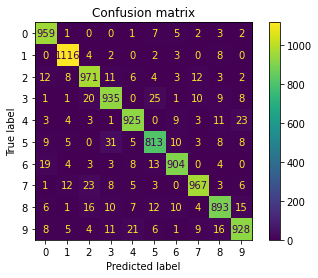

In [ ]:
bagging_pipeline=Pipeline([('classifier',BaggingClassifier())])
train_classifiers(bagging_pipeline,X_train,y_train.ravel(),cv,"bagging")
eval(bagging_pipeline, X_test, y_test)

##**Random Forest for MNIST multiclass classification**

On an average, random forest model has f1 score of 0.967 +/- 0.001 on the training side.
# Classification report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

#Confusion Matrix


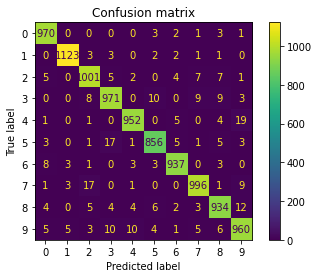

In [ ]:
random_forest_pipeline=Pipeline([('classifier',RandomForestClassifier())])
train_classifiers(random_forest_pipeline,X_train,y_train.ravel(),cv,"random forest")
eval(random_forest_pipeline, X_test, y_test)

## Summary:
- We trained three multi-class classifiers for handwritten digit recognition
- The decision tree classifiers is a baseline classifier, which obtained accuracy of 88% on the test set
- Using bagging and training the same decision tree classifier gave us an increase of 6 percentage point in the accuracy, which translates to 94% accuracy on the test set
- Finally random forest pushed that further to 97%
We can see that how ensemble techniques give better results on the classification task compared to a single classifier
- With this demonstration, you have added three more powerful tools in your ML toolkit

#**Bagging and Random Forest Regressor on California Housing Dataset**

In [ ]:
np.random.seed(306)

In [ ]:
cv=ShuffleSplit(n_splits=10,test_size=0.2, random_state=42)

In [7]:
features, labels=fetch_california_housing(as_frame=True, return_X_y=True)
labels *=100

#train-test split
com_train_features, test_features, com_train_labels, test_labels=train_test_split(
    features, labels, random_state=42
)

#train--> train+ dev split
train_features, dev_features, train_labels, dev_labels = train_test_split(
    com_train_features, com_train_labels, random_state=42
)

## Training different regressors

In [ ]:
def train_regressor(estimator, X_train, y_train, cv, name):
  cv_results = cross_validate(estimator,
                              X_train,
                              y_train,
                              cv=cv,
                              scoring="neg_mean_absolute_error",
                              return_train_score=True,
                              return_estimator=True
                              )
  cv_train_error=-1*cv_results['train_score']
  cv_test_error=-1*cv_results['test_score']
  print(f"On an average, {name} makes an error of "
        f"{cv_train_error.mean():.3f} +/- {cv_train_error.std():.3f} on the training side.")
  print(f"On an average, {name} makes an error of "
        f"{cv_test_error.mean():.3f} +/- {cv_test_error.std():.3f} on the test side.")

In [ ]:
#@title Decision Tree Regressor
train_regressor(
    DecisionTreeRegressor(),com_train_features,
    com_train_labels,cv,'decision tree regressor'
)

On an average, decision tree regressor makes an error of 0.000 +/- 0.000 on the training side.
On an average, decision tree regressor makes an error of 47.259 +/- 1.142 on the test side.


In [ ]:
#@title Bagging Regressor
train_regressor(
    BaggingRegressor(),com_train_features,
    com_train_labels,cv,'bagging regressor'
)

On an average, bagging regressor makes an error of 14.377 +/- 0.196 on the training side.
On an average, bagging regressor makes an error of 35.217 +/- 0.608 on the test side.


In [ ]:
#@title RandomForest Regressor
train_regressor(
    RandomForestRegressor(),com_train_features,
    com_train_labels,cv,'random forest regressor'
)

On an average, random forest regressor makes an error of 12.642 +/- 0.071 on the training side.
On an average, random forest regressor makes an error of 33.198 +/- 0.718 on the test side.


## Parameter Search for random forest regressor

In [ ]:
param_distributions={
    "n_estimators":[1,2,5,10,20,50,100,200,500],
    "max_leaf_nodes":[2,5,10,20,50,100]
}
search_cv=RandomizedSearchCV(
    RandomForestRegressor(n_jobs=2), param_distributions=param_distributions,
    scoring="neg_mean_absolute_error",n_iter=10,random_state=0, n_jobs=2,
)
search_cv.fit(com_train_features, com_train_labels)
columns=[f"param_{name}" for name in param_distributions.keys()]
columns+=['mean_test_error', 'std_test_error']
cv_results=pd.DataFrame(search_cv.cv_results_)
cv_results['mean_test_error']=-cv_results['mean_test_score']
cv_results['std_test_error']=cv_results['std_test_score']
cv_results[columns].sort_values(by="mean_test_error")

,param_n_estimators,param_max_leaf_nodes,mean_test_error,std_test_error
0,500,100,40.628785,0.687056
2,10,100,41.349402,0.924073
7,100,50,43.755560,0.753236
8,1,100,47.589140,1.506743
1,100,20,49.489855,1.056522
6,50,20,49.540090,1.018944
9,10,20,50.042758,1.262516
3,500,10,55.056201,1.105694
4,5,5,61.588725,0.927725
5,5,2,73.084580,0.978585


In [ ]:
error=-search_cv.score(test_features,test_labels)
print(f"On average, our random forest regressor makes an error of {error:.2f}k$ ")

On average, our random forest regressor makes an error of 40.46k$ 


#**AdaBoost and GradientBoost Classifier on MNIST**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
cv=ShuffleSplit(n_splits=10,test_size=0.2,random_state=42)

In [ ]:
def train_classifiers(estimator, X_train,y_train,cv,name):
  estimator.fit(X_train, y_train)
  cv_train_score=cross_val_score(estimator,X_train, y_train,
                                 cv=cv, scoring='f1_macro')
  print(f"On an average, {name} model has f1 score of "
        f"{cv_train_score.mean():.3f} +/- {cv_train_score.std():.3f} on the training side.")
def eval(estimator, X_test,y_test):
  y_pred=estimator.predict(X_test)
  print('# Classification report')
  print(classification_report(y_test, y_pred))

  print('#Confusion Matrix')
  disp=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred))
  disp.plot()
  plt.title('Confusion matrix')
  plt.show()

Adaboost Classifiers that uses decision stumps as weak learners
GradientBoostingClassifier that uses decision trees as weak learners

On an average, AdaBoostClassifier model has f1 score of 0.712 +/- 0.016 on the training side.
# Classification report
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       980
           1       0.85      0.94      0.90      1135
           2       0.79      0.58      0.67      1032
           3       0.68      0.67      0.68      1010
           4       0.72      0.72      0.72       982
           5       0.69      0.59      0.64       892
           6       0.72      0.86      0.78       958
           7       0.68      0.78      0.73      1028
           8       0.66      0.68      0.67       974
           9       0.62      0.55      0.58      1009

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.72     10000
weighted avg       0.73      0.73      0.73     10000

#Confusion Matrix


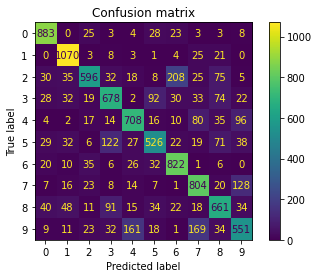

In [ ]:
#@title AdaBoost for MNIST classification
abc_pipeline=Pipeline([('classifier',AdaBoostClassifier())])
train_classifiers(abc_pipeline,X_train,y_train.ravel(),cv,"AdaBoostClassifier")
eval(abc_pipeline, X_test, y_test)

In [ ]:
#@title MNIST classification with GradientBoostClassifier
gbc_pipeline=Pipeline([('classifier',GradientBoostingClassifier())])
train_classifiers(gbc_pipeline,X_train,y_train.ravel(),cv,"GradientBoostingClassifier")
eval(gbc_pipeline, X_test, y_test)

In [3]:
#@title MNIST classification with XGBoost classifier
from xgboost import XGBClassifier

In [4]:
?XGBClassifier

In [ ]:
xbc_pipeline=Pipeline([("classifier",XGBClassifier())])
train_classifiers(xbc_pipeline, X_train, y_train.ravel(),cv,
                 "XGBClassifier")
eval(xbc_pipeline,X_test,y_test)

#**AdaBoost and GradientBoost Regressor on California Housing**

In [5]:
np.random.seed(306)

In [6]:
cv=ShuffleSplit(n_splits=10,test_size=0.2,random_state=42)

In [8]:
def train_regressor(estimator, X_train, y_train, cv, name):
  cv_results = cross_validate(estimator,
                              X_train,
                              y_train,
                              cv=cv,
                              scoring="neg_mean_absolute_error",
                              return_train_score=True,
                              return_estimator=True
                              )
  cv_train_error=-1*cv_results['train_score']
  cv_test_error=-1*cv_results['test_score']
  print(f"On an average, {name} makes an error of "
        f"{cv_train_error.mean():.3f} +/- {cv_train_error.std():.3f} on the training side.")
  print(f"On an average, {name} makes an error of "
        f"{cv_test_error.mean():.3f} +/- {cv_test_error.std():.3f} on the test side.")

In [9]:
#@title AdaBoostRegressor
train_regressor(
    AdaBoostRegressor(),com_train_features,
    com_train_labels,cv,'AdaBoostRegressor'
)

On an average, AdaBoostRegressor makes an error of 73.263 +/- 6.031 on the training side.
On an average, AdaBoostRegressor makes an error of 73.623 +/- 6.057 on the test side.


In [10]:
#@title GradientBoostingRegressor
train_regressor(
    GradientBoostingRegressor(),com_train_features,
    com_train_labels,cv,'GradientBoostingRegressor'
)

On an average, GradientBoostingRegressor makes an error of 35.394 +/- 0.273 on the training side.
On an average, GradientBoostingRegressor makes an error of 36.773 +/- 0.723 on the test side.


## XGBoost

In [11]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Extreme gradient boosting(XGBoost) is the latest boosting technique. It is more regualrized form of gradient boosting. With regularization, it is able to achieve better generalization performance than gradient boositng

In [12]:
from xgboost import XGBRegressor
xgb_regressor = XGBRegressor(objective='reg:squarederror')

In [13]:
train_regressor(
    xgb_regressor,com_train_features,
    com_train_labels,cv,'XGBRegressor'
)

On an average, XGBRegressor makes an error of 35.441 +/- 0.228 on the training side.
On an average, XGBRegressor makes an error of 36.815 +/- 0.707 on the test side.
